In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import math
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)

ETL dataset

In [7]:
# Read a CSV file into a DataFrame
csv_file_path = "../Dataset/XRPUSDT/XRPUSDT_5min.csv"  # Replace with your CSV file path
xrp_df = pd.read_csv(csv_file_path)

xrp_df['timestamp'] = pd.to_datetime(xrp_df['timestamp'])
xrp_df = xrp_df[xrp_df['timestamp'].dt.year >= 2025]

In [8]:
def getATR(df, period):
    # Calculate the True Range (TR)
    df['high_low'] = df['high'] - df['low']
    df['high_close'] = abs(df['high'] - df['close'].shift())
    df['low_close'] = abs(df['low'] - df['close'].shift())
    df['tr'] = df[['high_low', 'high_close', 'low_close']].max(axis=1)

    # Calculate the Average True Range (ATR) with Wilder's method 
    df['atr'] = df['tr'].ewm(alpha=1/period, adjust=False).mean()

    return df

In [9]:
def getADX(df, period):
    high = df['high']
    low  = df['low']

    up_move = high.diff()
    down_move = -low.diff()

    plus_dm = np.where((up_move > down_move) & (up_move > 0), up_move, 0.0)
    minus_dm = np.where((up_move < down_move) & (down_move > 0), down_move, 0.0)


    df = getATR(df.copy(), period)

    plus_dm_ewm = pd.Series(plus_dm, index=df.index).ewm(alpha=1/period, adjust=False).mean()
    minus_dm_ewm = pd.Series(minus_dm, index=df.index).ewm(alpha=1/period, adjust=False).mean()

    plus_di = 100 * (plus_dm_ewm / df['atr'])
    minus_di = 100 * (minus_dm_ewm / df['atr'])

    dx = 100 * abs(plus_di - minus_di) / (plus_di + minus_di)
    adx = dx.ewm(alpha=1/period, adjust=False).mean()

    return plus_di, minus_di, adx, df['atr']


In [10]:
tp = 2
sl = 1

trend_df = pd.DataFrame()

trend_df['timestamp'] = xrp_df['timestamp']

#SMA
trend_df['SMA_fast'] = xrp_df['close'].rolling(window=5).mean()
trend_df['SMA_slow'] = xrp_df['close'].rolling(window=20).mean()

#MACD
trend_df['EMA_fast'] = xrp_df['close'].ewm(span=12, adjust=False).mean()
trend_df['EMA_slow'] = xrp_df['close'].ewm(span=26, adjust=False).mean()
trend_df['MACD'] = trend_df['EMA_fast'] - trend_df['EMA_slow']
trend_df['Signal_Line'] = trend_df['MACD'].ewm(span=9, adjust=False).mean()

#ADX
adx = getADX(xrp_df, 14)
trend_df['plus_di'] = pd.DataFrame(adx[0]).rename(columns = {0:'plus_di'})
trend_df['minus_di'] = pd.DataFrame(adx[1]).rename(columns = {0:'minus_di'})
trend_df['adx'] = pd.DataFrame(adx[2]).rename(columns = {0:'adx'})
trend_df['take_profit'] = tp * getADX(xrp_df, 14)[3]
trend_df['stop_loss'] = sl * getADX(xrp_df, 14)[3]

trend_df.dropna(inplace = True)
trend_df.reset_index(drop=True, inplace=True)


In [11]:
trend_df.head()

,timestamp,SMA_fast,SMA_slow,EMA_fast,EMA_slow,MACD,Signal_Line,plus_di,minus_di,adx,take_profit,stop_loss
0,2025-01-01 01:35:00,2.10130,2.100740,2.101862,2.098143,0.003719,0.004258,23.889642,11.444314,68.095289,0.012009,0.006004
1,2025-01-01 01:40:00,2.10192,2.101670,2.102037,2.098503,0.003534,0.004113,22.587487,11.305025,65.609122,0.011794,0.005897
2,2025-01-01 01:45:00,2.10280,2.102235,2.102339,2.098910,0.003429,0.003976,21.335116,12.896028,62.683702,0.011594,0.005797
3,2025-01-01 01:50:00,2.10212,2.102215,2.101410,2.098717,0.002693,0.003720,18.946777,18.640381,58.264521,0.012123,0.006062
4,2025-01-01 01:55:00,2.10038,2.102015,2.100316,2.098389,0.001927,0.003361,17.795095,19.414307,54.413599,0.011986,0.005993


In [12]:
xrp_df.head()

,timestamp,open,high,low,close
699717,2025-01-01 00:00:00,2.0836,2.0869,2.0811,2.0844
699718,2025-01-01 00:05:00,2.0845,2.0931,2.0844,2.0927
699719,2025-01-01 00:10:00,2.0926,2.0967,2.0893,2.0967
699720,2025-01-01 00:15:00,2.0968,2.1019,2.0953,2.0983
699721,2025-01-01 00:20:00,2.0983,2.1011,2.0948,2.0974


Add Signals

In [13]:
def checkMACD(EMA_fast, EMA_slow, MACD, signal_line):
    if EMA_fast > EMA_slow and MACD > signal_line:
        return 1  # Buy signal
    elif EMA_fast < EMA_slow and MACD < signal_line:
        return -1  # Sell signal
    else:
        return 0  # No signal
    

In [14]:
def checkSMA(SMA_fast, SMA_slow):
    if SMA_fast > SMA_slow:
        return 1  # Buy signal
    elif SMA_fast < SMA_slow:
        return -1  # Sell signal
    else:
        return 0  # No signal

In [15]:
def checkADX(plus_di, minus_di, adx):
    if adx > 20 and plus_di > minus_di:
        return 1  # Buy signal
    elif adx > 20 and minus_di > plus_di:
        return -1  # Sell signal
    else:
        return 0  # No signal / Take Profit

In [16]:
def checkSignal(SMA, MACD, ADX):
    return SMA * MACD * ADX 

In [17]:
def addSignals(xrp_df, trend_df):
    xrp_df['SMA_Signal'] = trend_df.apply(lambda row: checkSMA(row['SMA_fast'], row['SMA_slow']), axis=1)
    xrp_df['MACD_Signal'] = trend_df.apply(lambda row: checkMACD(row['EMA_fast'], row['EMA_slow'], row['MACD'], row['Signal_Line']), axis=1)
    xrp_df['ADX_Signal'] = trend_df.apply(lambda row: checkADX(row['plus_di'], row['minus_di'], row['adx']), axis=1)
    
    # Combine the signals
    xrp_df['Combined_Signal'] = xrp_df.apply(lambda row: checkSignal(row['SMA_Signal'], row['MACD_Signal'], row['ADX_Signal']), axis=1)
    return xrp_df

In [18]:
trend_df = trend_df.reset_index(drop=True)
xrp_df = xrp_df.reset_index(drop=True)

xrp_df['take_profit'] = trend_df['take_profit']
xrp_df['stop_loss'] = trend_df['stop_loss']

xrp_df = addSignals(xrp_df, trend_df)

In [19]:
xrp_df.head()

,timestamp,open,high,low,close,take_profit,stop_loss,SMA_Signal,MACD_Signal,ADX_Signal,Combined_Signal
0,2025-01-01 00:00:00,2.0836,2.0869,2.0811,2.0844,0.012009,0.006004,1.0,0.0,1.0,0.0
1,2025-01-01 00:05:00,2.0845,2.0931,2.0844,2.0927,0.011794,0.005897,1.0,0.0,1.0,0.0
2,2025-01-01 00:10:00,2.0926,2.0967,2.0893,2.0967,0.011594,0.005797,1.0,0.0,1.0,0.0
3,2025-01-01 00:15:00,2.0968,2.1019,2.0953,2.0983,0.012123,0.006062,-1.0,0.0,1.0,-0.0
4,2025-01-01 00:20:00,2.0983,2.1011,2.0948,2.0974,0.011986,0.005993,-1.0,0.0,-1.0,0.0


In [18]:
trend_df.head()

,timestamp,SMA_fast,SMA_slow,EMA_fast,EMA_slow,MACD,Signal_Line,plus_di,minus_di,adx,take_profit,stop_loss
0,2025-01-01 01:35:00,2.10130,2.100740,2.101862,2.098143,0.003719,0.004258,23.889642,11.444314,68.095289,0.012009,0.006004
1,2025-01-01 01:40:00,2.10192,2.101670,2.102037,2.098503,0.003534,0.004113,22.587487,11.305025,65.609122,0.011794,0.005897
2,2025-01-01 01:45:00,2.10280,2.102235,2.102339,2.098910,0.003429,0.003976,21.335116,12.896028,62.683702,0.011594,0.005797
3,2025-01-01 01:50:00,2.10212,2.102215,2.101410,2.098717,0.002693,0.003720,18.946777,18.640381,58.264521,0.012123,0.006062
4,2025-01-01 01:55:00,2.10038,2.102015,2.100316,2.098389,0.001927,0.003361,17.795095,19.414307,54.413599,0.011986,0.005993


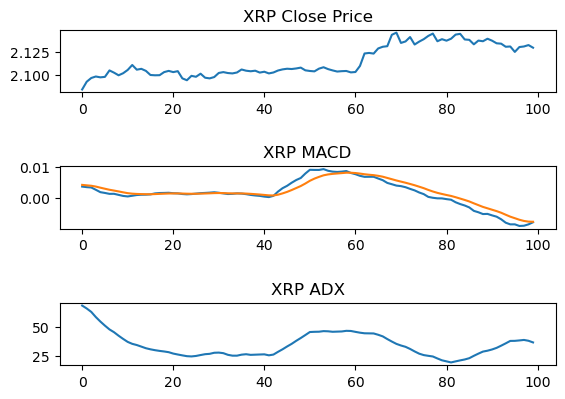

In [18]:
xrp_df_clone = xrp_df[['timestamp', 'close']][:100]
trend_df_clone = trend_df[['MACD', 'Signal_Line', 'adx']][:100]

ax = plt.subplot2grid((11,1), (0,0), rowspan = 2, colspan = 2)
ax.plot(xrp_df_clone['close'])

ax1 = plt.subplot2grid((11,1), (4,0), rowspan = 2, colspan = 2)
ax1.plot(trend_df_clone['MACD'])
ax1.plot(trend_df_clone['Signal_Line'])

ax2 = plt.subplot2grid((11,1), (8,0), rowspan = 2, colspan = 2)  
ax2.plot(trend_df_clone['adx'])

ax.set_title('XRP Close Price')
ax1.set_title('XRP MACD')
ax2.set_title('XRP ADX')
plt.show()

Base Strategy Backtest

In [19]:
initial_investment = 200
investment_per_trade = 200
total_investment_amount = 200
entry_price = 0
current_shares = 0 
profit = 0
hold = False
signal = None
signal_list = []

total_trades = 0
errors = 0

for i in range(len(xrp_df)):
    row = xrp_df.iloc[i]
    current_price = row['close']

    # No position held
    if not hold:
        if row['Combined_Signal'] == 1:  # Buy signal
            signal = "buy"
            entry_price = current_price
            current_shares = investment_per_trade / entry_price  
            hold = True
            total_trades += 1
            signal_list.append("buy")
        elif row['Combined_Signal'] == -1:  # Sell signal
            signal = "sell"
            entry_price = current_price
            current_shares = investment_per_trade / entry_price  
            hold = True
            total_trades += 1
            signal_list.append("sell")
        else:
            signal_list.append("skip")
    
    # When holding a position
    else:  
        # Calculate profit or loss
        if signal == "buy":
            profit = (current_price - entry_price) * current_shares 
        elif signal == "sell":
            profit = (entry_price - current_price) * current_shares

        # Check take profit and stop loss conditions
        if profit >= row['take_profit'] or profit <= row['stop_loss']:
            total_investment_amount += profit  # Update investment amount with the profit or loss from this trade
            if profit < 0:
                errors += 1
            hold = False  # Exit the position
            profit = 0  # Reset after trade is closed
            signal_list.append("take profit")
        else:
            signal_list.append("hold")

    xrp_df.loc[i, 'investment_overtime'] = total_investment_amount  # Track investment over time

    
    # Check how much to trade
    if total_investment_amount < investment_per_trade:
        investment_per_trade = total_investment_amount
    else: investment_per_trade = 200

    # Check if investment is depleted
    if total_investment_amount <= 0:
        print(f"Investment depleted at iteration {i} on {xrp_df['timestamp'].iloc[i]}")
        break

# Fill remaining signal list if necessary
if len(signal_list) < len(xrp_df):
    signal_list.extend(["skip"] * (len(xrp_df) - len(signal_list)))

xrp_df['signal'] = signal_list


In [20]:
investment_value = 200
profit_percentage = math.floor((total_investment_amount/initial_investment)*100)
error_percentage = 0
if errors > 0:
    error_percentage = math.floor(errors/total_trades * 100)

print("Profit gained from the strategy by investing P200 in XRP : " + str(round(total_investment_amount, 2)))
print("Profit percentage of the strategy : " + str(profit_percentage))
print("Total Trades: ", total_trades)
print("Errors: ", errors)
print("Error Percentage: ", error_percentage, "%")

Profit gained from the strategy by investing P200 in XRP : 520.52
Profit percentage of the strategy : 260
Total Trades:  5765
Errors:  2730
Error Percentage:  47 %


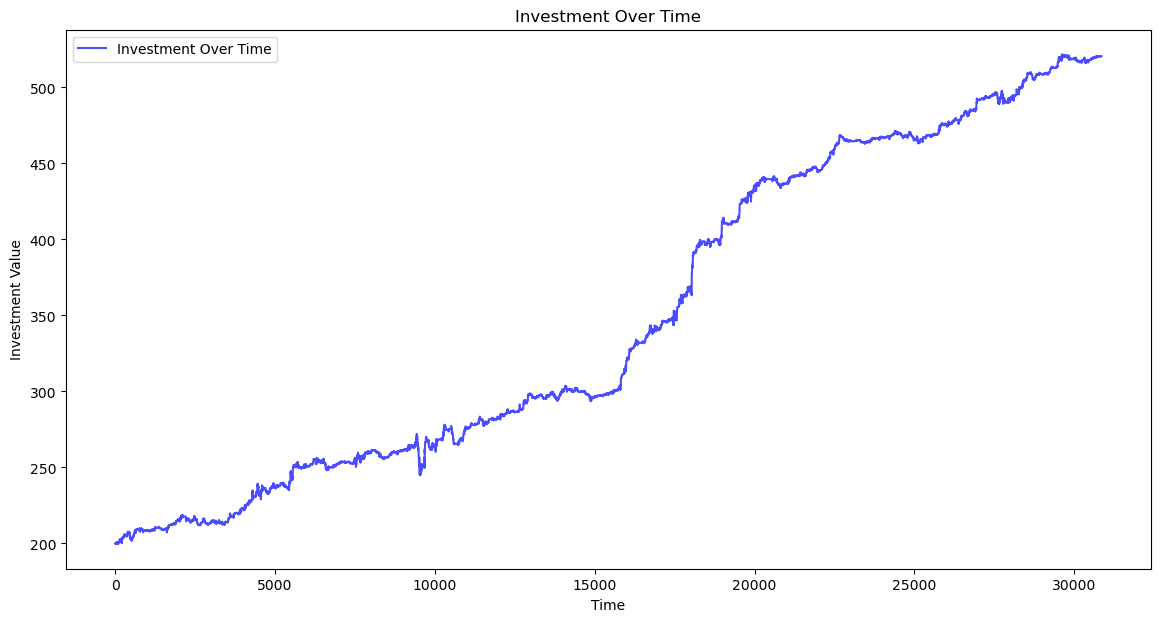

In [21]:
plt.figure(figsize=(14, 7))
plt.plot(xrp_df['investment_overtime'], label="Investment Over Time", color="blue", alpha=0.7)
plt.title("Investment Over Time")
plt.xlabel("Time")
plt.ylabel("Investment Value")
plt.legend()
plt.show()

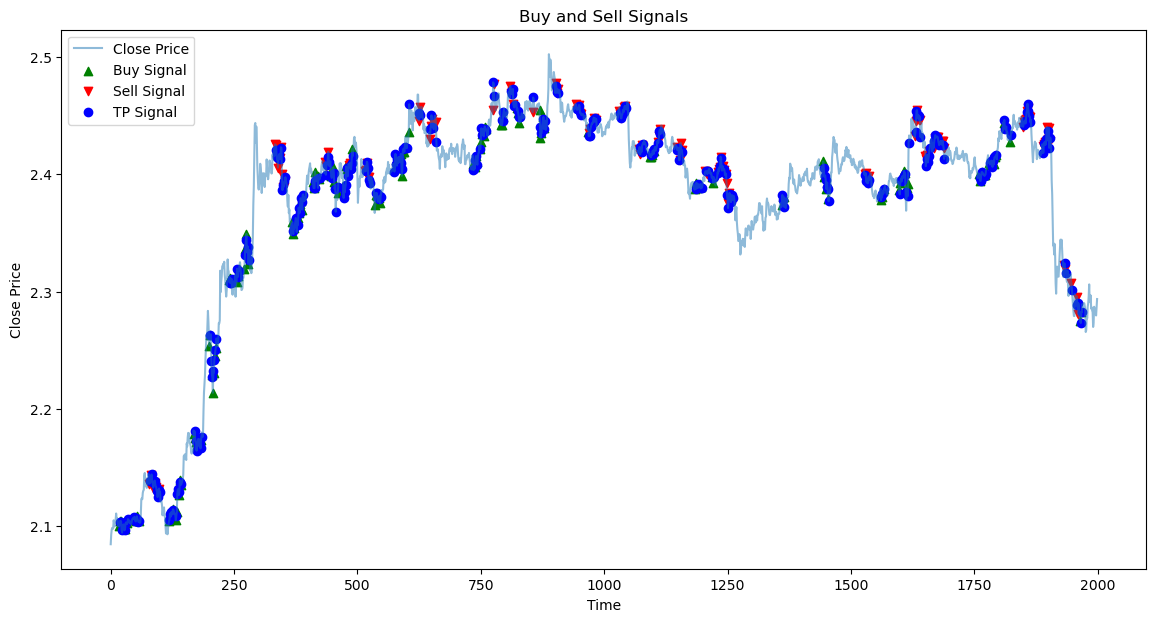

In [22]:
xrp_df_clone = xrp_df.iloc[:2000].copy()


plt.figure(figsize=(14, 7))
plt.plot(xrp_df_clone['close'], label="Close Price", alpha=0.5)
buy_signals = xrp_df_clone[xrp_df_clone['signal'] == "buy"]
sell_signals = xrp_df_clone[xrp_df_clone['signal'] == "sell"]
tp_signals = xrp_df_clone[xrp_df_clone['signal'] == "take profit"]
plt.scatter(buy_signals.index, buy_signals['close'], label="Buy Signal", marker="^", color="green", alpha=1)
plt.scatter(sell_signals.index, sell_signals['close'], label="Sell Signal", marker="v", color="red", alpha=1)
plt.scatter(tp_signals.index, tp_signals['close'], label="TP Signal", marker="o", color="blue", alpha=1)
plt.title("Buy and Sell Signals")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.show()


Python Code Implementation

In [3]:
xrp_df.head()

,timestamp,open,high,low,close
699717,2025-01-01 00:00:00,2.0836,2.0869,2.0811,2.0844
699718,2025-01-01 00:05:00,2.0845,2.0931,2.0844,2.0927
699719,2025-01-01 00:10:00,2.0926,2.0967,2.0893,2.0967
699720,2025-01-01 00:15:00,2.0968,2.1019,2.0953,2.0983
699721,2025-01-01 00:20:00,2.0983,2.1011,2.0948,2.0974


In [142]:
#dataset
first_day = xrp_df['timestamp'].dt.date.min()
xrp_first_day_rows = xrp_df[xrp_df['timestamp'].dt.date == first_day]

xrp_simulation_data = xrp_df[xrp_df['timestamp'].dt.date > first_day]
xrp_simulation_data = xrp_simulation_data[['timestamp', 'open', 'high', 'low', 'close']]
columns_to_add = ['SMA_fast', 'SMA_slow', 'EMA_fast', 'EMA_slow', 'MACD', 'Signal_Line', 
                  'plus_di', 'minus_di', 'adx']
xrp_first_day_rows = xrp_first_day_rows.join(trend_df[columns_to_add])


In [143]:
xrp_first_day_rows.tail()

,timestamp,open,high,low,close,take_profit,stop_loss,SMA_Signal,MACD_Signal,ADX_Signal,Combined_Signal,SMA_fast,SMA_slow,EMA_fast,EMA_slow,MACD,Signal_Line,plus_di,minus_di,adx
283,2025-01-01 23:35:00,2.3279,2.3285,2.3166,2.3178,0.036907,0.018454,1.0,0.0,1.0,0.0,2.39204,2.384545,2.396449,2.379352,0.017098,0.021141,25.122686,19.069992,31.303480
284,2025-01-01 23:40:00,2.3179,2.3241,2.3172,2.3205,0.036714,0.018357,1.0,0.0,1.0,0.0,2.39414,2.389105,2.398380,2.381548,0.016832,0.020280,27.770181,17.801125,30.630069
285,2025-01-01 23:45:00,2.3205,2.3255,2.3140,2.3157,0.036192,0.018096,1.0,0.0,1.0,0.0,2.39744,2.393340,2.399429,2.383300,0.016130,0.019450,26.356193,16.768225,30.030298
286,2025-01-01 23:50:00,2.3156,2.3241,2.3145,2.3231,0.035292,0.017646,1.0,0.0,1.0,0.0,2.40012,2.397575,2.399579,2.384566,0.015012,0.018562,25.218739,15.967299,29.489745
287,2025-01-01 23:55:00,2.3231,2.3332,2.3216,2.3328,0.037014,0.018507,-1.0,0.0,-1.0,0.0,2.39868,2.400625,2.397197,2.384532,0.012665,0.017383,22.327971,25.483996,27.854829


In [144]:
xrp_simulation_data.head()

,timestamp,open,high,low,close
288,2025-01-02 00:00:00,2.3329,2.3554,2.3297,2.3464
289,2025-01-02 00:05:00,2.3464,2.3827,2.3407,2.3745
290,2025-01-02 00:10:00,2.3745,2.3985,2.3685,2.3895
291,2025-01-02 00:15:00,2.3895,2.4192,2.3873,2.4174
292,2025-01-02 00:20:00,2.4174,2.4477,2.4106,2.4420


In [145]:
def editDataFrame(df, newData):

    df = df.iloc[1:]

    new_data_df = pd.DataFrame(newData)
    new_data_df['timestamp'] = pd.to_datetime(new_data_df['timestamp'])
    df = pd.concat([df, new_data_df], ignore_index=True)

    return df



In [146]:
def calculateATR(df, period):
    # Calculate the True Range (TR)

    high_low = df.loc[df.index[-1], 'high'] - df.loc[df.index[-1], 'low']
    high_close = abs(df.loc[df.index[-1], 'high'] - df.loc[df.index[-1], 'close'].shift())
    low_close = abs(df.loc[df.index[-1], 'low'] - df.loc[df.index[-1], 'close'].shift())

    df.loc[df.index[-1], 'high_low'] = high_low
    df.loc[df.index[-1], 'high_close'] = high_close
    df.loc[df.index[-1], 'low_close'] = low_close
    df.loc[df.index[-1], 'tr'] = max(high_low, high_close, low_close)

    # Calculate the Average True Range (ATR) with Wilder's method 
    df.loc[df.index[-1], 'atr'] = df.loc[df.index[-1], 'tr'].ewm(alpha=1/period, adjust=False).mean()

    return df

In [147]:
def calculateADX(df, period):
    up_move = df['high'].diff()
    down_move = -df['low'].diff()

    if up_move.iloc[-1] > down_move.iloc[-1] and up_move.iloc[-1] > 0:
        df.loc[df.index[-1], "plus_dm"] = up_move.iloc[-1]
    else: df.loc[df.index[-1], "plus_dm"] = 0

    if up_move.iloc[-1] < down_move.iloc[-1] and down_move.iloc[-1] > 0:
        df.loc[df.index[-1], "minus_dm"] = down_move.iloc[-1]
    else: df.loc[df.index[-1], "minus_dm"] = 0

    df = getATR(df.copy(), period)

    df['plus_dm'].iloc[-period:].ewm(alpha=1/period, adjust=False).mean()

    
    plus_dm_ewm = df['plus_dm'].iloc[-period:].ewm(alpha=1/period, adjust=False).mean()
    minus_dm_ewm = df['minus_dm'].iloc[-period:].ewm(alpha=1/period, adjust=False).mean()

    plus_di = 100 * (plus_dm_ewm / df['atr'])
    minus_di = 100 * (minus_dm_ewm / df['atr'])

    dx = 100 * abs(plus_di - minus_di) / (plus_di + minus_di)
    adx = dx.ewm(alpha=1/period, adjust=False).mean()

    return plus_di, minus_di, adx, df['atr']


In [148]:
def calculateSMA(df, slow, fast):

    df.loc[df.index[-1], 'SMA_fast'] = df['close'].iloc[-fast:].mean()
    df.loc[df.index[-1], 'SMA_slow'] = df['close'].iloc[-slow:].mean()

    return df

In [149]:
def calculateMACD(df, slow, fast, signal):

    df.loc[df.index[-1], 'EMA_fast'] = df['close'].iloc[-fast:].ewm(span=fast, adjust=False).mean().iloc[-1]
    df.loc[df.index[-1], 'EMA_slow'] = df['close'].iloc[-slow:].ewm(span=slow, adjust=False).mean().iloc[-1]
    df.loc[df.index[-1], 'MACD'] = df['EMA_fast'].iloc[-1] - df['EMA_slow'].iloc[-1]
    df.loc[df.index[-1], 'Signal_Line'] = df['MACD'].iloc[-signal:].ewm(span=signal, adjust=False).mean().iloc[-1]

    return df


In [150]:
def calculateTPSL(df, adx, tp, sl):
    
    df.loc[df.index[-1],'take_profit'] = tp * adx
    df.loc[df.index[-1],'stop_loss'] = sl * adx

    return df


In [155]:
def checkMACD(EMA_fast, EMA_slow, MACD, signal_line):
    if EMA_fast > EMA_slow and MACD > signal_line:
        return 1  # Buy signal
    elif EMA_fast < EMA_slow and MACD < signal_line:
        return -1  # Sell signal
    else:
        return 0  # No signal
    

In [156]:
def checkSMA(SMA_fast, SMA_slow):
    if SMA_fast > SMA_slow:
        return 1  # Buy signal
    elif SMA_fast < SMA_slow:
        return -1  # Sell signal
    else:
        return 0  # No signal

In [157]:
def checkADX(plus_di, minus_di, adx):
    if adx > 20 and plus_di > minus_di:
        return 1  # Buy signal
    elif adx > 20 and minus_di > plus_di:
        return -1  # Sell signal
    else:
        return 0  # No signal / Take Profit

In [158]:
def checkSignal(SMA, MACD, ADX):
    return SMA * MACD * ADX 

In [159]:
def addSignals(df):

    sma = checkSMA(df.loc[df.index[-1], 'SMA_fast'], df.loc[df.index[-1], 'SMA_slow'])
    macd = checkMACD(df.loc[df.index[-1], 'EMA_fast'], df.loc[df.index[-1], 'EMA_slow'], df.loc[df.index[-1], 'MACD'], df.loc[df.index[-1], 'Signal_Line'])
    adx = checkADX(df.loc[df.index[-1], 'plus_di'], df.loc[df.index[-1], 'minus_di'], df.loc[df.index[-1], 'adx'])

    df.loc[df.index[-1], 'SMA_Signal'] = sma
    df.loc[df.index[-1], 'MACD_Signal'] = macd
    df.loc[df.index[-1], 'ADX_Signal'] = adx
    
    # Combine the signals
    df.loc[df.index[-1], 'Combined_Signal'] = checkSignal(sma, macd, adx)
    
    return df

In [162]:
def prepareDataset(cryptoDf):
    
    for i in range(len(xrp_simulation_data)):
        
        timestamp = xrp_simulation_data['timestamp'].iloc[i]
        open = xrp_simulation_data['open'].iloc[i]
        high = xrp_simulation_data['high'].iloc[i]
        low = xrp_simulation_data['low'].iloc[i]
        close = xrp_simulation_data['close'].iloc[i]

        new_data = [{
            'timestamp': timestamp, 
            'open': open, 
            'high': high, 
            'low': low, 
            'close': close
        }]

        cryptoDf = editDataFrame(cryptoDf, new_data)

        # get signals
        cryptoDf = calculateSMA(cryptoDf, 20, 5)
        cryptoDf = calculateMACD(cryptoDf, 26, 12, 9)

        adx = calculateADX(crypto_df, 14)
        cryptoDf.loc[cryptoDf.index[-1],'plus_di'] = adx[0].iloc[-1]
        cryptoDf.loc[cryptoDf.index[-1],'minus_di'] = adx[1].iloc[-1]
        cryptoDf.loc[cryptoDf.index[-1],'adx'] = adx[2].iloc[-1]

        cryptoDf = calculateTPSL(cryptoDf, adx[3].iloc[-1], tp, sl)
        cryptoDf = addSignals(cryptoDf)

    return cryptoDf


In [ ]:
def checkTradeSignal(cryptoDf, amount):
    pass

In [ ]:
crypto_df = xrp_first_day_rows.copy()

prepared_crypto_df = prepareDataset(crypto_df)
checkTradeSignal(prepared_crypto_df)
